In [1]:
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from lfpan import *
from utils import resample, filter_from_coefs, despine_ax, rescaling
from lfpmodel import optimize_params, deriv_LFP, get_stim_func

In [2]:
mean_kdes, mean_lfps, tt_full = get_means(cutoff=50, leave_out=[9], span=(-3,8), dt=1e-4)

In [3]:
t_min = -0.1
t_max = .4
tt = np.linspace(-.1, t_max, 500)

varrs_resampled = [resample(tt_full, (-mean_lfps[dur]), tt) for dur in [0.02, 0.2, 2]]

In [4]:
res_min = optimize_params(varrs_resampled)
print(res_min)

      fun: 18.79782162044729
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.09226469,  0.74705256, -2.32027178, -0.73907719])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 65
      nit: 3
     njev: 13
   status: 0
  success: True
        x: array([  6.57166338,   7.34765622,  40.62789097, 130.22059225])


In [9]:
params = res_min.x

max_step = 1e-3
t_min = -0.1
t_max = 4
tarr = np.linspace(t_min, t_max, 500)

ka, sa, kb, sb = params
conc = 1

deriv_params = ka, sa, kb, sb
deriv_func = deriv_LFP

args = (get_stim_func(0.2, conc), *deriv_params)
y0 = np.array([1, 0, 0, 0])
res = solve_ivp(deriv_LFP, t_span=(t_min,t_max), y0=y0, args=args, t_eval=tarr, max_step=max_step)
rescaling = varrs_resampled[1].max() / res.y[-1].max()

In [21]:
print(rescaling)
rescaling = 7.5

7


In [22]:
shapes = [1, 1, 1]
taus = [1e-3, 40e-3, 0.8]

tarr_filt, filt = filter_from_coefs([-96, 81, 15.5], taus, shapes, 1e-4)

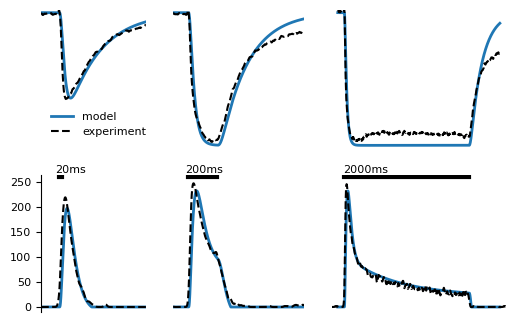

In [23]:
def plot_predictions(axes):
#     params = res_min.x
    params = 6.57318997,   7.35851112,  37.26683195, 130.39817691
    params = 0.28041614*th, 11.54237033, 13.78770442, 27.59664759

    t_min = -0.1
    t_max = 2.5
    tarr = np.arange(t_min, t_max, 1e-4)

    max_step = 1e-3
    deriv_params = params
    ends = []

    varrs_resampled_dense = [resample(tt_full, (list(mean_lfps.values())[i]), tarr) for i in range(3)]
    
    xlims = [
        (-0.1, 0.5),
        (-0.1, 0.8),
        (-0.2, 2.6)
    ]
    
    for i, (dur, xlim) in enumerate(zip([.02, .2, 2], xlims)):
        ax_col = axes[:,i]
        
        args = (get_stim_func(dur), *deriv_params)
        y0 = np.array([1, 0, 0, 0])
        res = solve_ivp(deriv_LFP, t_span=(t_min,t_max), y0=y0, args=args, t_eval=tarr, max_step=max_step)

        varr = -res.y[-1]*rescaling
        firing = np.clip(np.convolve(varr, filt[::1], mode='full')[:-len(filt)+1], a_min=0, a_max=None)
        ax_col[0].plot(tarr, varr, lw=2, label='model')
        ax_col[0].plot(tarr, varrs_resampled_dense[i], color='black', linestyle='dashed', label='experiment')
        
        ax_col[1].plot(tarr, firing, lw=2)
        
        ax_col[1].set_ylim(-10, 265)
        ax_col[1].plot([0, dur], [260, 260], lw=3, color='black')
        ax_col[1].text(-0.02, 268, f'{dur*1000:.0f}ms')
        
        ax_col[1].plot(tt_full, list(mean_kdes.values())[i], color='black', linestyle='dashed')
        
        for ax in ax_col:
            ax.set_xlim(xlim)
            
    for ax in axes[0]:
        ax.set_ylim(-5.1,0.1)
        despine_ax(ax, remove_ticks=True)
        
    for i, ax in enumerate(axes[1]):
        if i == 0:
            there = 'b'
        else:
            there = None
            
        despine_ax(ax, where=there, remove_ticks=True)
        
        
fig, axes = plt.subplots(nrows=2, ncols=3, gridspec_kw={'width_ratios': [0.6, 0.75, 1]})
plot_predictions(axes)
axes[0,0].legend(frameon=False)

# plt.savefig('img/transduction_model.png')